# PCA Feature Selection for Proteomic Data

This notebook performs Principal Component Analysis (PCA) to identify and keep only the most important protein features before SSL training.

**Goals:**
- Reduce dimensionality while preserving variance
- Remove noise and redundant features
- Visualize feature importance
- Prepare optimal features for TabNet SSL training


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [4]:
# Load the proteomic dataset
input_data = r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_23Jun2025.csv"
train = pd.read_csv(input_data)

print(f"Dataset shape: {train.shape}")
print(f"Columns: {list(train.columns)}")
train.head()


Dataset shape: (303, 322)
Columns: ['RID', 'VISCODE', 'A1AT_AVLTIDEK', 'A1AT_LSITGTYDLK', 'A1AT_SVLGQLGITK', 'A1BG_NGVAQEPVHLDSPAIK', 'A1BG_SGLSTGWTQLSK', 'A2GL_DLLLPQPDLR', 'A2GL_VAAGAFQGLR', 'A4_LVFFAEDVGSNK', 'A4_THPHFVIPYR', 'A4_WYFDVTEGK', 'AACT_ADLSGITGAR', 'AACT_EIGELYLPK', 'AACT_NLAVSQVVHK', 'AATC_IVASTLSNPELFEEWTGNVK', 'AATC_LALGDDSPALK', 'AATC_NLDYVATSIHEAVTK', 'AATM_FVTVQTISGTGALR', 'AFAM_DADPDTFFAK', 'AFAM_FLVNLVK', 'AFAM_LPNNVLQEK', 'ALDOA_ALQASALK', 'ALDOA_QLLLTADDR', 'AMBP_AFIQLWAFDAVK', 'AMBP_ETLLQDFR', 'AMBP_FLYHK', 'AMD_IPVDEEAFVIDFKPR', 'AMD_IVQFSPSGK', 'AMD_NGQWTLIGR', 'APLP2_HYQHVLAVDPEK', 'APLP2_WYFDLSK', 'APOB_IAELSATAQEIIK', 'APOB_SVSLPSLDPASAK', 'APOB_TGISPLALIK', 'APOD_VLNQELR', 'APOE_AATVGSLAGQPLQER', 'APOE_CLAVYQAGAR', 'APOE_LAVYQAGAR', 'APOE_LGADMEDVR', 'APOE_LGPLVEQGR', 'B2MG_VEHSDLSFSK', 'B2MG_VNHVTLSQPK', 'B3GN1_EPGEFALLR', 'B3GN1_TALASGGVLDASGDYR', 'B3GN1_YEAAVPDPR', 'BACE1_SIVDSGTTNLR', 'BASP1_ETPAATEAPSSTPK', 'BTD_LSSGLVTAALYGR', 'BTD_SHLIIAQVAK', 'C1

,RID,VISCODE,A1AT_AVLTIDEK,A1AT_LSITGTYDLK,A1AT_SVLGQLGITK,A1BG_NGVAQEPVHLDSPAIK,A1BG_SGLSTGWTQLSK,A2GL_DLLLPQPDLR,A2GL_VAAGAFQGLR,A4_LVFFAEDVGSNK,...,UBB_TLSDYNIQK,VASN_NLHDLDVSDNQLER,VASN_SLTLGIEPVSPTSLR,VASN_YLQGSSVQLR,VGF_AYQGVAAPFPK,VGF_NSEPQDEGELFQGVDPR,VGF_THLGEALAPLSK,VTDB_EFSHLGK,VTDB_HLSLLTTLSNR,VTDB_VPTADLEDVLPLAEDITNILSK
0,3,bl,10.09220,7.74523,10.17220,16.6720,21.4594,26.9142,24.2002,17.5886,...,22.6556,14.8820,12.4679,15.9046,16.7334,18.3733,15.7735,10.82520,21.7876,17.6057
1,4,bl,10.94970,7.70817,9.57396,14.9759,19.5672,25.3480,22.5761,17.9311,...,22.4333,14.5208,11.9206,15.5596,17.1372,19.1806,15.8797,9.33075,19.0783,15.5337
2,5,bl,9.98930,6.60892,9.68137,15.2048,19.7987,25.7420,22.8861,18.0174,...,22.9884,14.3662,12.1692,15.7139,17.9062,19.4055,16.8510,9.17437,19.1255,15.0267
3,8,bl,9.81022,7.65311,10.21570,15.6723,20.3279,25.4989,22.4874,18.6170,...,23.8482,15.4665,13.1469,16.5607,19.6158,21.2765,18.4325,9.86449,20.2941,16.1640
4,10,bl,8.92968,7.58228,9.95119,15.7266,20.1880,26.0936,23.2094,18.1481,...,23.0269,14.9748,12.4011,15.8251,17.6525,19.5023,16.5219,9.27747,19.8080,15.8384


In [5]:
# Prepare features (exclude metadata columns)
metadata_columns = ['RID', 'VISCODE', 'Set']
feature_columns = [col for col in train.columns if col not in metadata_columns]

print(f"Total features: {len(feature_columns)}")
print(f"Feature columns: {feature_columns[:10]}...")  # Show first 10

# Extract feature matrix
X = train[feature_columns].values
print(f"\nFeature matrix shape: {X.shape}")

# Check for missing values
missing_values = pd.DataFrame(X).isnull().sum().sum()
print(f"Missing values: {missing_values}")

# Handle missing values if any
if missing_values > 0:
    X = pd.DataFrame(X).fillna(0).values
    print("✅ Missing values filled with 0")


Total features: 320
Feature columns: ['A1AT_AVLTIDEK', 'A1AT_LSITGTYDLK', 'A1AT_SVLGQLGITK', 'A1BG_NGVAQEPVHLDSPAIK', 'A1BG_SGLSTGWTQLSK', 'A2GL_DLLLPQPDLR', 'A2GL_VAAGAFQGLR', 'A4_LVFFAEDVGSNK', 'A4_THPHFVIPYR', 'A4_WYFDVTEGK']...

Feature matrix shape: (303, 320)
Missing values: 0


In [6]:
# Split data for validation
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train, X_valid = train_test_split(X_train, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_valid.shape}")
print(f"Test set: {X_test.shape}")


Training set: (193, 320)
Validation set: (49, 320)
Test set: (61, 320)


In [7]:
def analyze_pca_components(X_train, X_valid, X_test, feature_names, max_components=None):
    """
    Comprehensive PCA analysis to determine optimal number of components
    """
    print("=== PCA ANALYSIS ===\n")
    
    # 1. Standardize features (crucial for PCA)
    print("1. Standardizing features...")
    scaler = StandardScaler() #apply Z-score normalization
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)
    
    # 2. Fit PCA with all components to analyze variance
    print("2. Fitting PCA to analyze variance...")
    n_features = X_train.shape[1]
    if max_components is None:
        max_components = min(n_features, X_train.shape[0] - 1)
    
    pca_full = PCA(n_components=max_components)
    pca_full.fit(X_train_scaled)
    
    # 3. Calculate variance metrics
    explained_var_ratio = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)
    
    # Find components for different variance thresholds
    thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
    component_counts = {}
    
    print("\n3. Variance analysis:")
    for threshold in thresholds:
        n_comp = np.argmax(cumulative_var >= threshold) + 1
        component_counts[threshold] = n_comp
        print(f"   {threshold*100:.0f}% variance: {n_comp:3d} components ({n_comp/n_features*100:.1f}% of original)")
    
    return pca_full, scaler, explained_var_ratio, cumulative_var, component_counts

# Run PCA analysis
pca_analysis, scaler, var_ratios, cum_var, comp_counts = analyze_pca_components(
    X_train, X_valid, X_test, feature_columns
)


=== PCA ANALYSIS ===

1. Standardizing features...
2. Fitting PCA to analyze variance...

3. Variance analysis:
   80% variance:  13 components (4.1% of original)
   85% variance:  22 components (6.9% of original)
   90% variance:  35 components (10.9% of original)
   95% variance:  59 components (18.4% of original)
   99% variance: 112 components (35.0% of original)


In [ ]:
# Simple PCA variance summary
print("=== PCA VARIANCE SUMMARY ===\n")
cumulative_var = np.cumsum(var_ratios)

key_thresholds = [0.8, 0.9, 0.95]
for threshold in key_thresholds:
    n_comp = np.argmax(cumulative_var >= threshold) + 1
    print(f"📊 {threshold*100:.0f}% variance: {n_comp} components ({n_comp/320*100:.1f}% of original)")

print(f"\n🎯 Recommendation: Use 90% threshold (35 components) for optimal balance")


Analyzing protein contributions to principal components...

=== PRINCIPAL COMPONENT ANALYSIS ===

📊 **PC1** (explains 49.02% variance)
🔬 **Top 8 Contributing Proteins:**
   + NCAM1_GLGEISAASEFK        | Loading:   0.077
   + NEO1_DVVASLVSTR           | Loading:   0.077
   + B3GN1_EPGEFALLR           | Loading:   0.076
   + FAM3C_SPFEQHIK            | Loading:   0.076
   + SE6L1_SPTNTISVYFR         | Loading:   0.076
   + CADM3_SLVTVLGIPQKPIITGYK  | Loading:   0.076
   + NRCAM_YIVSGTPTFVPYLIK     | Loading:   0.075
   + DAG1_LVPVVNNR             | Loading:   0.075

💡 **Interpretation:**
   • Positive loadings: proteins that increase with PC1
   • Negative loadings: proteins that decrease with PC1
   • PC1 represents a biological pattern involving these 8 proteins


📊 **PC2** (explains 15.98% variance)
🔬 **Top 8 Contributing Proteins:**
   + VTDB_VPTADLEDVLPLAEDITNILSK | Loading:   0.121
   + KNG1_TVGSDTFYSFK          | Loading:   0.121
   + HEMO_QGHNSVFLIK           | Loading:   0.120
 

=== VARIANCE THRESHOLD ANALYSIS ===

🎯 **50% Variance Threshold:**
   • Components needed: **PC1 through PC2**
   • Actual variance captured: **0.650** (65.0%)
   • Reduction: **320 → 2** features (0.6% of original)
   • Key components contributing:
     - PC1: 49.02% variance
     - PC2: 15.98% variance

🎯 **80% Variance Threshold:**
   • Components needed: **PC1 through PC13**
   • Actual variance captured: **0.805** (80.5%)
   • Reduction: **320 → 13** features (4.1% of original)
   • Key components contributing:
     - PC1: 49.02% variance
     - PC2: 15.98% variance
     - PC3: 4.00% variance
     - PC4: 2.29% variance
     - PC5: 1.78% variance
     - PC6-PC13: 7.42% variance (8 components)

🎯 **85% Variance Threshold:**
   • Components needed: **PC1 through PC22**
   • Actual variance captured: **0.854** (85.4%)
   • Reduction: **320 → 22** features (6.9% of original)
   • Key components contributing:
     - PC1: 49.02% variance
     - PC2: 15.98% variance
     - PC3: 4.00% vari

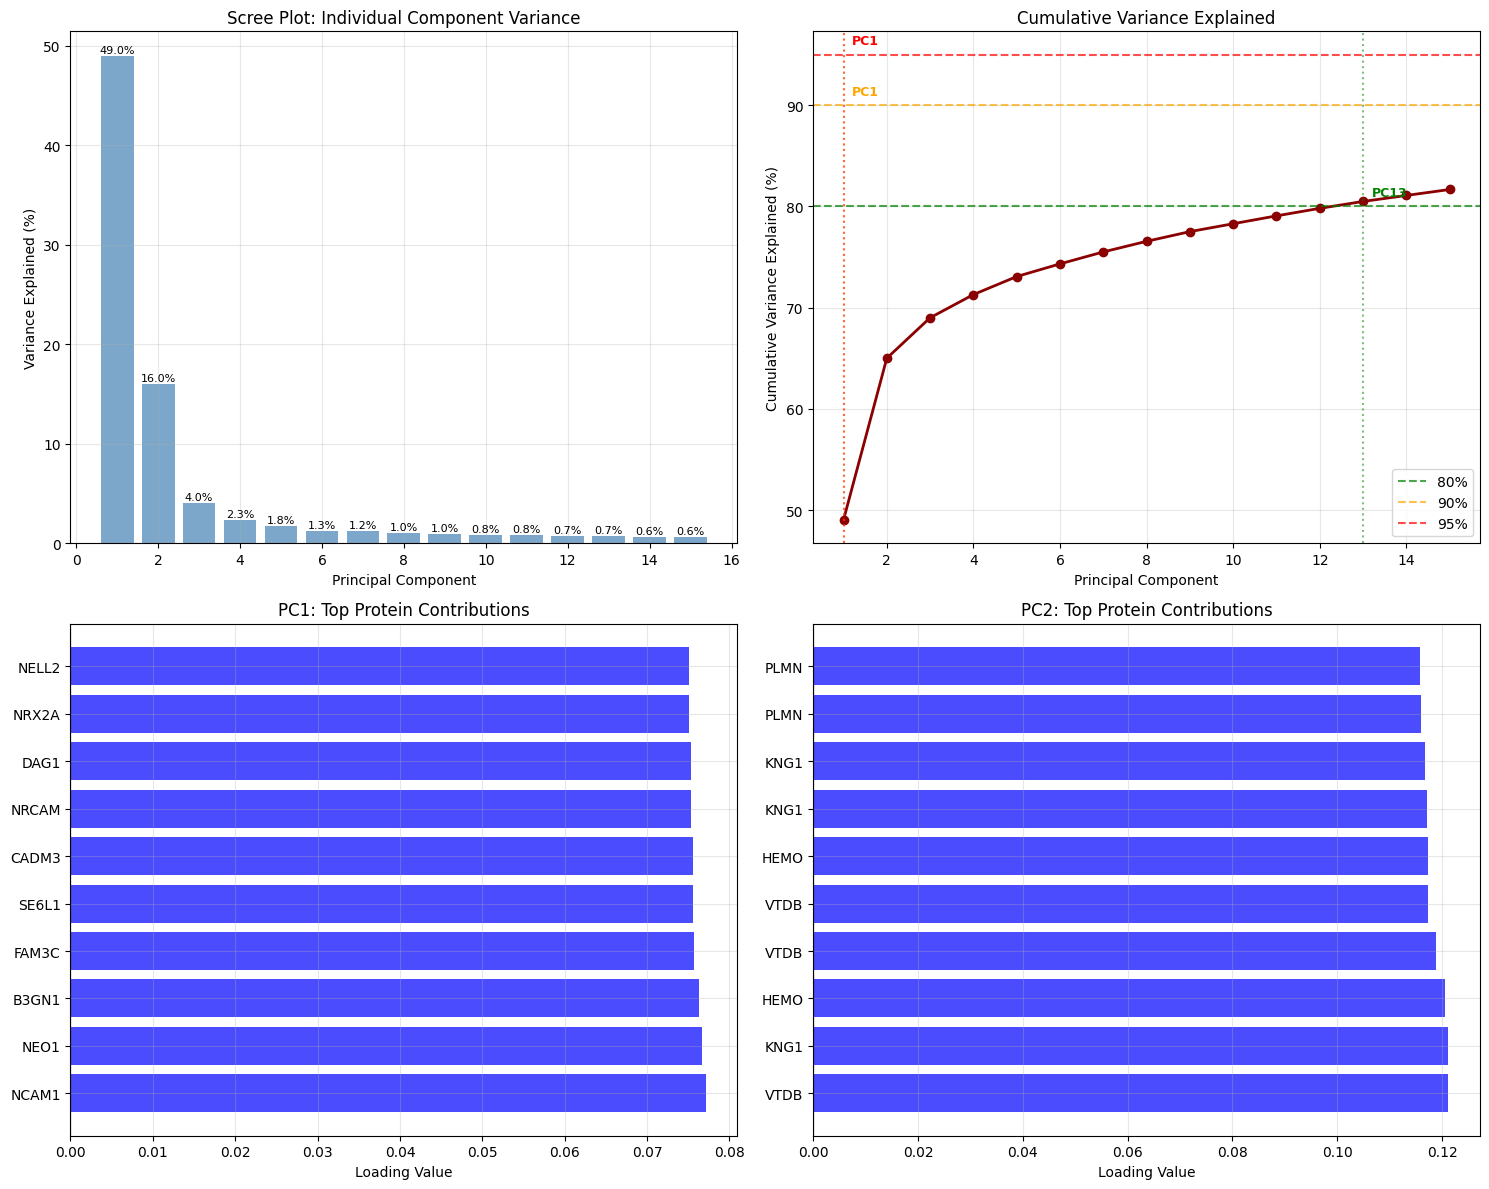

In [13]:
def create_pca_reduced_dataset(variance_threshold=0.95, save_path=None):
    """
    Simple PCA reduction: keep top proteins that capture specified variance
    
    Args:
        variance_threshold (float): Variance to retain (e.g., 0.95 for 95%)
        save_path (str): Path to save reduced dataset (optional)
    
    Returns:
        pd.DataFrame: Reduced dataset with metadata + top proteins
    """
    print(f"🎯 Creating PCA-reduced dataset with {variance_threshold*100:.0f}% variance...")
    
    # 1. Find number of components needed
    cumulative_var = np.cumsum(var_ratios)
    n_components = np.argmax(cumulative_var >= variance_threshold) + 1
    actual_variance = cumulative_var[n_components - 1]
    
    print(f"   • Components needed: {n_components}")
    print(f"   • Actual variance captured: {actual_variance:.3f} ({actual_variance*100:.1f}%)")
    
    # 2. Get top contributing proteins across all components
    # Create PCA with exact number of components needed
    pca_reduced = PCA(n_components=n_components)
    X_train_scaled = scaler.transform(X_train)
    pca_reduced.fit(X_train_scaled)
    
    # Calculate protein importance across all components
    components = pca_reduced.components_  # Shape: (n_components, n_features)
    protein_importance = np.sum(np.abs(components), axis=0)  # Sum absolute loadings
    
    # Get indices of top proteins
    top_protein_indices = np.argsort(protein_importance)[-n_components:][::-1]
    selected_proteins = [feature_columns[i] for i in top_protein_indices]
    
    print(f"   • Selected top {len(selected_proteins)} proteins based on PCA loadings")
    print(f"   • Dimensionality reduction: {len(feature_columns)} → {len(selected_proteins)} ({len(selected_proteins)/len(feature_columns)*100:.1f}%)")
    
    # 3. Create reduced dataset with selected proteins
    reduced_df = train[['RID', 'VISCODE'] + selected_proteins].copy()
    
    print(f"   • Final dataset shape: {reduced_df.shape}")
    print(f"   • Selected proteins: {selected_proteins[:5]}..." if len(selected_proteins) > 5 else f"   • Selected proteins: {selected_proteins}")
    
    # 4. Save if path provided
    if save_path:
        reduced_df.to_csv(save_path, index=False)
        print(f"   ✅ Saved to: {save_path}")
    
    # 5. Show sample of reduced data
    print(f"\n📊 Sample of reduced dataset:")
    print(reduced_df.head())
    
    return reduced_df, selected_proteins, pca_reduced

# Example usage - create 95% variance dataset
output_path = r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_PCA95_reduced.csv"

reduced_dataset, pca_model, fitted_scaler = create_pca_reduced_dataset(
    variance_threshold=0.95,  # Keep 95% variance
    save_path=output_path
)


🎯 Creating PCA-reduced dataset with 95% variance...
   • Components needed: 59
   • Actual variance captured: 0.951 (95.1%)
   • Selected top 59 proteins based on PCA loadings
   • Dimensionality reduction: 320 → 59 (18.4%)
   • Final dataset shape: (303, 61)
   • Selected proteins: ['TGFB1_LLAPSDSPEWLSFDVTGVVR', 'CATD_YSQAVPAVTEGPIPEVLK', 'A1AT_AVLTIDEK', 'CO3_VPVAVQGEDTVQSLTQGDGVAK', 'APOE_CLAVYQAGAR']...
   ✅ Saved to: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_PCA95_reduced.csv

📊 Sample of reduced dataset:
   RID VISCODE  TGFB1_LLAPSDSPEWLSFDVTGVVR  CATD_YSQAVPAVTEGPIPEVLK  \
0    3      bl                     10.3696                  16.7719   
1    4      bl                     10.7777                  18.4952   
2    5      bl                     10.0884                  16.9116   
3    8      bl                     10.4895                  17.7181   
4   10      bl                     10.6151                  18.2329   

   A1AT_AVLTIDEK  CO3_V

In [14]:
# Quick function calls for different variance thresholds

print("="*60)
print("🚀 QUICK PCA DATASET CREATION")
print("="*60)

# Create datasets with different variance thresholds
thresholds_to_create = [0.80, 0.90, 0.95]

for threshold in thresholds_to_create:
    print(f"\n📁 Creating {threshold*100:.0f}% variance dataset...")
    
    output_file = rf"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_PCA{threshold*100:.0f}_reduced.csv"
    
    dataset, _, _ = create_pca_reduced_dataset(
        variance_threshold=threshold,
        save_path=output_file
    )
    print("-" * 50)


🚀 QUICK PCA DATASET CREATION

📁 Creating 80% variance dataset...
🎯 Creating PCA-reduced dataset with 80% variance...
   • Components needed: 13
   • Actual variance captured: 0.805 (80.5%)
   • Selected top 13 proteins based on PCA loadings
   • Dimensionality reduction: 320 → 13 (4.1%)
   • Final dataset shape: (303, 15)
   • Selected proteins: ['SODE_VTGVVLFR', 'SODE_AGLAASLAGPHSIVGR', 'SODE_AVVVHAGEDDLGR', 'ENPP2_WWGGQPLWITATK', 'CO4A_VLSLAQEQVGGSPEK']...
   ✅ Saved to: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_PCA80_reduced.csv

📊 Sample of reduced dataset:
   RID VISCODE  SODE_VTGVVLFR  SODE_AGLAASLAGPHSIVGR  SODE_AVVVHAGEDDLGR  \
0    3      bl        25.5216                15.4349             19.3779   
1    4      bl        25.1427                15.2339             19.6968   
2    5      bl        24.8310                15.1127             18.8159   
3    8      bl        25.2510                15.0405             18.7096   
4   10      bl    